In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg
from disp import set_font_size
from my_stats import nanpearsonr

cc = np.concatenate

FPS_DN = 8.5  # sampling rate from neural data
DT_DN = 1/FPS_DN
NT_H_DN = 85
T_H_DN = np.arange(NT_H_DN)*DT_DN

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS
NT_H = int(round(NT_H_DN*FPS/FPS_DN))
T_H = np.arange(NT_H)*DT

H_S_COLS = [f'IT_H_S_{it}' for it in range(NT_H_DN)]
H_P_COLS = [f'IT_H_P_{it}' for it in range(NT_H_DN)]

SAVE_DIR_LIN = 'data/simple/mlv_c/song_heurs/c_baker_lin_song_heur'
PFX_LIN = 'mlv_c_baker_lin_song_heur'

SAVE_DIR_LN = 'data/simple/mlv_c/song_heurs/c_baker_ln_song_heur'
PFX_LN = 'mlv_c_baker_ln_song_heur'

SAVE_DIR_DYN = 'data/simple/mlv_c/song_heurs/c_baker_dyn_song_heur'
PFX_DYN = 'mlv_c_baker_dyn_song_heur'

WDW_SONG_HEUR = 10

if not os.path.exists(SAVE_DIR_LIN):
    os.makedirs(SAVE_DIR_LIN)
if not os.path.exists(SAVE_DIR_LN):
    os.makedirs(SAVE_DIR_LN)
if not os.path.exists(SAVE_DIR_DYN):
    os.makedirs(SAVE_DIR_DYN)

Load behavioral data from Coen et al 2014

In [2]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002
...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090


In [3]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in range(n_tr)]

tr_lens = np.array([len(df_tr) for df_tr in dfs_tr])
tr_lens_cum = cc([[0], np.cumsum(tr_lens)])

n_t_total = np.sum(tr_lens)
assert n_t_total == tr_lens_cum[-1]
df_behav = None

In [4]:
# compute song heuristics
def get_n_s_onsets(df_tr, wdw):
    s = np.array(df_tr['S']).astype(int)
    s_onsets = np.diff(cc([[0], s])) > 0
    s_onsets_wdw = signal.fftconvolve(s_onsets, np.ones(int(round(wdw/DT))), mode='full')[:len(df_tr)]
    return np.round(s_onsets_wdw).astype(int)
    
def get_n_p_onsets(df_tr, wdw):
    p = np.array(df_tr['P']|df_tr['F']).astype(int)
    p_onsets = np.diff(cc([[0], p])) > 0
    p_onsets_wdw = signal.fftconvolve(p_onsets, np.ones(int(round(wdw/DT))), mode='full')[:len(df_tr)]
    return np.round(p_onsets_wdw).astype(int)

def get_n_b_onsets(df_tr, wdw):
    b = np.array(df_tr['S']|df_tr['P']|df_tr['F']).astype(int)
    b_onsets = np.diff(cc([[0], b])) > 0
    b_onsets_wdw = signal.fftconvolve(b_onsets, np.ones(int(round(wdw/DT))), mode='full')[:len(df_tr)]
    return np.round(b_onsets_wdw).astype(int)

def get_s_total(df_tr, wdw):
    s = np.array(df_tr['S']).astype(int)
    s_total = signal.fftconvolve(s, np.ones(int(round(wdw/DT))), mode='full')[:len(df_tr)]
    return s_total*DT

def get_p_total(df_tr, wdw):
    p = np.array(df_tr['P']|df_tr['F']).astype(int)
    p_total = signal.fftconvolve(p, np.ones(int(round(wdw/DT))), mode='full')[:len(df_tr)]
    return p_total*DT
    
def get_b_total(df_tr, wdw):
    b = np.array(df_tr['S']|df_tr['P']|df_tr['F']).astype(int)
    b_total = signal.fftconvolve(b, np.ones(int(round(wdw/DT))), mode='full')[:len(df_tr)]
    return b_total*DT

def get_mn_s_dur(df_tr, wdw):
    s_total = get_s_total(df_tr, wdw)
    n_s_onsets = get_n_s_onsets(df_tr, wdw)
    mvalid = n_s_onsets > .5
    mn_s_dur = np.nan * np.zeros(len(df_tr))
    mn_s_dur[mvalid] = s_total[mvalid]/n_s_onsets[mvalid]
    return mn_s_dur

def get_mn_p_dur(df_tr, wdw):
    p_total = get_p_total(df_tr, wdw)
    n_p_onsets = get_n_p_onsets(df_tr, wdw)
    mvalid = n_p_onsets > .5
    mn_p_dur = np.nan * np.zeros(len(df_tr))
    mn_p_dur[mvalid] = p_total[mvalid]/n_p_onsets[mvalid]
    return mn_p_dur

def get_mn_b_dur(df_tr, wdw):
    b_total = get_b_total(df_tr, wdw)
    n_b_onsets = get_n_b_onsets(df_tr, wdw)
    mvalid = n_b_onsets > .5
    mn_b_dur = np.nan * np.zeros(len(df_tr))
    mn_b_dur[mvalid] = b_total[mvalid]/n_b_onsets[mvalid]
    return mn_b_dur

def get_sp_ratio(df_tr, wdw):
    s_total = get_s_total(df_tr, wdw)
    p_total = get_p_total(df_tr, wdw)
    mvalid = p_total > (.5*DT)
    sp_ratio = np.nan * np.zeros(len(df_tr))
    sp_ratio[mvalid] = s_total[mvalid]/p_total[mvalid]
    return sp_ratio

SONG_HEURS = {
    'N_S_ONSETS': get_n_s_onsets, 'N_P_ONSETS': get_n_p_onsets, 'N_B_ONSETS': get_n_b_onsets,
    'S_TOTAL': get_s_total, 'P_TOTAL': get_p_total, 'B_TOTAL': get_b_total,
    'MN_S_DUR': get_mn_s_dur, 'MN_P_DUR': get_mn_p_dur, 'MN_B_DUR': get_mn_b_dur,
    'SP_RATIO': get_sp_ratio,
}

# Linear neural responses

Load params from linear fits on Baker et al data.

In [5]:
# neural response fits from Baker data
df_lin_param = pd.read_csv('data/simple/neur/baker_lin_fit_param.csv')
df_lin_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,IDUR_H,T_0,R_0,...,IT_H_P_75,IT_H_P_76,IT_H_P_77,IT_H_P_78,IT_H_P_79,IT_H_P_80,IT_H_P_81,IT_H_P_82,IT_H_P_83,IT_H_P_84
0,0,R70G01,0,somas,False,0.174497,1,85,0.235294,0,...,-0.154953,-0.073905,-0.007819,-0.506101,0.231079,0.131478,0.380165,1.043530,0.523804,-2.027452
1,1,R70G01,1,somas,False,0.173904,1,85,0.235294,0,...,-0.808924,0.464651,-0.320987,0.582338,0.282897,-0.153832,-0.394784,1.707338,-0.719647,-0.152941
2,2,R70G01,2,somas,False,0.170188,1,85,0.235294,0,...,-0.339182,0.267191,0.125736,-0.641290,0.483302,-0.417439,0.945032,1.250669,-0.291958,-0.910192
3,3,R70G01,3,somas,False,0.365310,1,85,0.235294,0,...,-1.042894,1.202923,-2.168054,0.977008,-0.909011,-1.937358,3.046854,-1.023927,0.129524,-1.712622
4,4,R70G01,4,somas,False,0.153828,1,85,0.235294,0,...,-0.511628,-0.399655,-0.150975,-0.333150,-0.033365,0.079399,0.435384,0.419418,0.733692,-2.437793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.220064,1,85,-0.470588,0,...,-1.653836,2.237410,-0.589508,-0.483772,1.333863,2.307638,-1.417966,-0.412455,-1.430931,0.913422
220,220,VT34811,0,ascending projection,False,0.066786,1,85,-0.705882,0,...,-0.013608,0.071371,-0.077927,-0.024410,-0.102891,0.050893,0.021110,-0.073407,0.014354,0.555983
221,221,vPN1_split,0,somas,False,0.421309,1,85,-0.941176,0,...,-0.091841,2.063789,-1.226476,-0.652369,2.441115,0.451942,-0.476302,3.120248,-0.000051,-2.094935
222,222,vPN1_split,1,somas,False,0.923838,1,85,-0.705882,0,...,9.607118,3.330856,-7.545851,4.314196,4.479567,-5.405843,-4.439488,12.160638,-2.870428,-9.383391


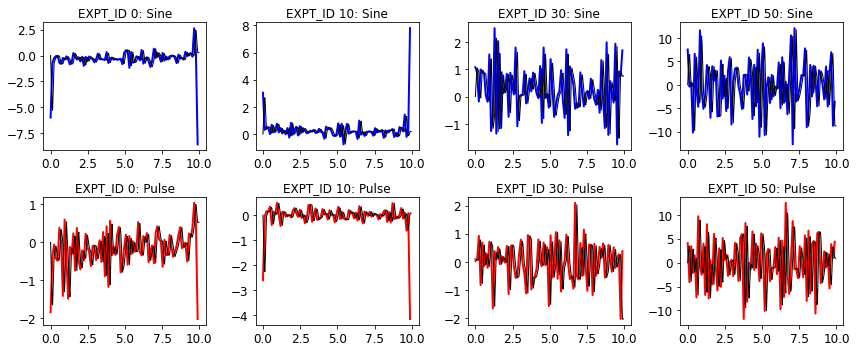

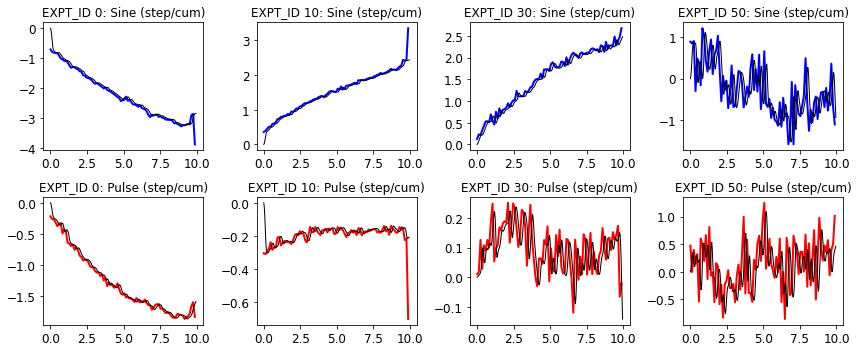

In [6]:
expt_ids = df_lin_param['EXPT_ID']

# extract filters (downsampled)
hs_dn_s = np.array([df_lin_param[expt_ids == expt_id].iloc[0][H_S_COLS] for expt_id in expt_ids]).astype(float)
hs_dn_p = np.array([df_lin_param[expt_ids == expt_id].iloc[0][H_P_COLS] for expt_id in expt_ids]).astype(float)

# upsample filters via interpolation
hs_s = np.array([np.interp(T_H, T_H_DN, cc([[0], h_dn_s])[:-1]) for h_dn_s in hs_dn_s])
hs_p = np.array([np.interp(T_H, T_H_DN, cc([[0], h_dn_p])[:-1]) for h_dn_p in hs_dn_p])

fig, axs = plt.subplots(2, 4, figsize=(12, 5), tight_layout=True)
for cexpt, ax_col in zip([0, 10, 30, 50], axs.T):
    ax_col[0].plot(T_H_DN, hs_dn_s[cexpt], c='b', lw=2)
    ax_col[0].plot(T_H, hs_s[cexpt], c='k', lw=1)
    ax_col[0].set_title(f'EXPT_ID {expt_ids[cexpt]}: Sine')
    
    ax_col[1].plot(T_H_DN, hs_dn_p[cexpt], c='r', lw=2)
    ax_col[1].plot(T_H, hs_p[cexpt], c='k', lw=1)
    ax_col[1].set_title(f'EXPT_ID {expt_ids[cexpt]}: Pulse')
    
set_font_size(axs, 12)

fig, axs = plt.subplots(2, 4, figsize=(12, 5), tight_layout=True)
for cexpt, ax_col in zip([0, 10, 30, 50], axs.T):
    ax_col[0].plot(T_H_DN, hs_dn_s[cexpt].cumsum()*DT_DN, c='b', lw=2)
    ax_col[0].plot(T_H, hs_s[cexpt].cumsum()*DT, c='k', lw=1)
    ax_col[0].set_title(f'EXPT_ID {expt_ids[cexpt]}: Sine (step/cum)')
    
    ax_col[1].plot(T_H_DN, hs_dn_p[cexpt].cumsum()*DT_DN, c='r', lw=2)
    ax_col[1].plot(T_H, hs_p[cexpt].cumsum()*DT, c='k', lw=1)
    ax_col[1].set_title(f'EXPT_ID {expt_ids[cexpt]}: Pulse (step/cum)')
    
set_font_size(axs, 12)

Neural responses are given by convolution of each neuron's impulse response with song

$$r(t) = h_{sine}(t) \circledast I_{sine}(t) + h_{pulse}(t) \circledast I_{pulse}(t) = \int_0^{\infty} h_{sine}(t') I_{sine}(t-t')dt' + \int_0^{\infty} h_{pulse}(t') I_{pulse}(t-t')dt'$$

In [7]:
# compute surrogate linear neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_lin = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for expt_id, h_s, h_p in zip(expt_ids, hs_s, hs_p):
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = DT*(signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] \
            + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)])
        
        df_tr_nrl_lin[f'R_{expt_id}'] = r
        
    # compute song heuristics
    for ksong_heur, song_heur_func in SONG_HEURS.items():
        df_tr_nrl_lin[ksong_heur] = song_heur_func(df_tr, WDW_SONG_HEUR)
        
    np.save(os.path.join(SAVE_DIR_LIN, f'{PFX_LIN}_wdw_{WDW_SONG_HEUR}_tr_{ctr}.npy'), np.array([{'df': df_tr_nrl_lin}]))

....................................................................................................................................................................................................................................................................................

# Linear-nonlinear neural responses

Load params from LN fits on Baker et al data.

In [8]:
# neural response fits from Baker data
df_ln_param = pd.read_csv('data/simple/neur/baker_ln_fit_param.csv')
df_ln_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,IDUR_H,T_0,R_MIN,...,IT_H_P_75,IT_H_P_76,IT_H_P_77,IT_H_P_78,IT_H_P_79,IT_H_P_80,IT_H_P_81,IT_H_P_82,IT_H_P_83,IT_H_P_84
0,0,R70G01,0,somas,False,0.116654,1,85,-0.588235,-3.415529,...,-0.734095,0.811377,-0.067731,-0.257040,-0.137581,0.384149,-0.360587,0.417339,0.160589,-0.026703
1,1,R70G01,1,somas,False,0.157722,1,85,-0.000000,-4.455353,...,-1.188191,0.431265,-0.379593,-0.141001,0.257382,0.720318,0.031915,1.152158,0.097212,-0.539837
2,2,R70G01,2,somas,False,0.216238,1,85,-0.705882,-9.401333,...,-0.216395,1.049489,-0.652327,-0.892429,2.073636,-0.499193,-0.163227,-0.592688,0.768063,0.935336
3,3,R70G01,3,somas,False,0.399637,1,85,-0.000000,-10.427291,...,-1.732860,-0.250369,1.469324,-2.890671,3.226214,-3.175536,-0.105929,-1.195380,-1.886349,1.462493
4,4,R70G01,4,somas,False,0.157962,1,85,-0.000000,-4.234239,...,-0.107905,0.067871,-0.247231,-0.176038,-0.245665,-0.303530,0.276232,0.114832,0.014329,-0.277528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.240074,1,85,-0.941176,-2.651729,...,-0.270258,0.708970,2.826822,-2.624359,-0.652230,0.865368,-0.779340,1.182712,0.918672,1.639929
220,220,VT34811,0,ascending projection,False,0.066822,1,85,-0.705882,-1.838089,...,0.120907,0.086056,-0.028436,-0.045641,-0.214481,0.216249,0.101994,0.017857,0.183708,0.556504
221,221,vPN1_split,0,somas,False,0.449277,1,85,-0.352941,-7.514724,...,2.654589,-1.975776,1.694190,0.508859,-3.986838,1.630318,-2.643436,-0.427851,2.896510,0.766496
222,222,vPN1_split,1,somas,False,1.020438,1,85,-0.705882,-9.407223,...,9.664129,12.435059,-12.459662,3.377176,6.525184,-3.782298,-15.511553,16.338576,-4.705969,-6.501855


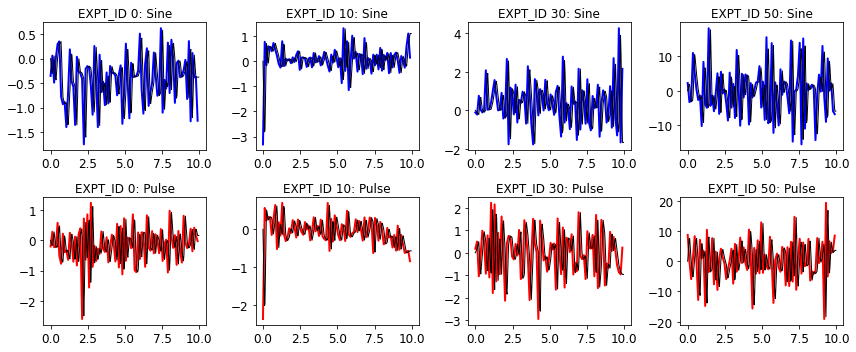

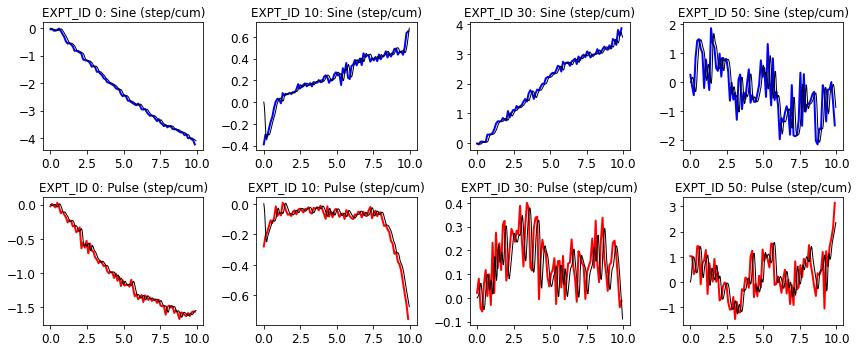

In [9]:
expt_ids = df_ln_param['EXPT_ID']

r_mins = np.array([df_ln_param[expt_ids == expt_id].iloc[0]['R_MIN'] for expt_id in expt_ids])
r_maxs = np.array([df_ln_param[expt_ids == expt_id].iloc[0]['R_MAX'] for expt_id in expt_ids])
z_0s = np.array([df_ln_param[expt_ids == expt_id].iloc[0]['Z_0'] for expt_id in expt_ids])
betas = np.array([df_ln_param[expt_ids == expt_id].iloc[0]['BETA'] for expt_id in expt_ids])

# extract filters (downsampled)
hs_dn_s = np.array([df_ln_param[expt_ids == expt_id].iloc[0][H_S_COLS] for expt_id in expt_ids]).astype(float)
hs_dn_p = np.array([df_ln_param[expt_ids == expt_id].iloc[0][H_P_COLS] for expt_id in expt_ids]).astype(float)

# # upsample filters via interpolation
hs_s = np.array([np.interp(T_H, T_H_DN, cc([[0], h_dn_s])[:-1]) for h_dn_s in hs_dn_s])
hs_p = np.array([np.interp(T_H, T_H_DN, cc([[0], h_dn_p])[:-1]) for h_dn_p in hs_dn_p])

fig, axs = plt.subplots(2, 4, figsize=(12, 5), tight_layout=True)
for cexpt, ax_col in zip([0, 10, 30, 50], axs.T):
    ax_col[0].plot(T_H_DN, hs_dn_s[cexpt], c='b', lw=2)
    ax_col[0].plot(T_H, hs_s[cexpt], c='k', lw=1)
    ax_col[0].set_title(f'EXPT_ID {expt_ids[cexpt]}: Sine')
    
    ax_col[1].plot(T_H_DN, hs_dn_p[cexpt], c='r', lw=2)
    ax_col[1].plot(T_H, hs_p[cexpt], c='k', lw=1)
    ax_col[1].set_title(f'EXPT_ID {expt_ids[cexpt]}: Pulse')
    
set_font_size(axs, 12)

fig, axs = plt.subplots(2, 4, figsize=(12, 5), tight_layout=True)
for cexpt, ax_col in zip([0, 10, 30, 50], axs.T):
    ax_col[0].plot(T_H_DN, hs_dn_s[cexpt].cumsum()*DT_DN, c='b', lw=2)
    ax_col[0].plot(T_H, hs_s[cexpt].cumsum()*DT, c='k', lw=1)
    ax_col[0].set_title(f'EXPT_ID {expt_ids[cexpt]}: Sine (step/cum)')
    
    ax_col[1].plot(T_H_DN, hs_dn_p[cexpt].cumsum()*DT_DN, c='r', lw=2)
    ax_col[1].plot(T_H, hs_p[cexpt].cumsum()*DT, c='k', lw=1)
    ax_col[1].set_title(f'EXPT_ID {expt_ids[cexpt]}: Pulse (step/cum)')
    
set_font_size(axs, 12)

Neural responses are given by convolution of each neuron's impulse response with song
$$z(t) = h_{sine}(t) \circledast I_{sine}(t) + h_{pulse}(t) \circledast I_{pulse}(t)$$
$$r(t) = r_{min} + (r_{max} - r_{min})\left[\frac{\tanh(\beta(z - z_0)) - 1}{2}\right]$$

In [10]:
def smlt(i_s, i_p, h_s, h_p, r_min, r_max, z_0, beta):
    """Simulate response to song inputs."""
    z = DT*(signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)])
    
    return r_min + (r_max-r_min)*(np.tanh(beta*(z-z_0)) + 1)/2


# compute surrogate neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_ln = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for expt_id, h_s, h_p, r_min, r_max, z_0, beta in zip(expt_ids, hs_s, hs_p, r_mins, r_maxs, z_0s, betas):
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = smlt(i_s, i_p, h_s, h_p, r_min, r_max, z_0, beta)
        df_tr_nrl_ln[f'R_{expt_id}'] = r
        
    # compute song heuristics
    for ksong_heur, song_heur_func in SONG_HEURS.items():
        df_tr_nrl_ln[ksong_heur] = song_heur_func(df_tr, WDW_SONG_HEUR)

    np.save(os.path.join(SAVE_DIR_LN, f'{PFX_LN}_wdw_{WDW_SONG_HEUR}_tr_{ctr}.npy'), np.array([{'df': df_tr_nrl_ln}]))

....................................................................................................................................................................................................................................................................................

# Nonlinear adaptive dynamical system neural responses

Load params from dynamical systems fits to Baker et al data

In [11]:
# neural response fits from Baker data
df_dyn_param = pd.read_csv('data/simple/neur/baker_dyn_fit_param.csv')
df_dyn_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P
0,0,R70G01,0,somas,False,0.275200,True,-0.000000,0.028882,6.202615,30.336758,-4.958290,-2.597432
1,1,R70G01,1,somas,False,0.186212,True,0.117647,0.025128,3.835468,21.821295,-4.163967,-1.472075
2,2,R70G01,2,somas,False,0.248414,True,-0.000000,0.055962,6.017162,15.058055,-6.248007,-2.095952
3,3,R70G01,3,somas,False,0.455963,True,-0.000000,-0.014227,6.016828,11.820576,-5.679735,-2.118245
4,4,R70G01,4,somas,False,0.229018,True,-0.000000,0.019831,6.434825,55.496220,-4.415761,-2.863647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.276087,True,-0.000000,0.039119,1.799608,1440.994269,-0.049828,2.494657
220,220,VT34811,0,ascending projection,False,0.037801,True,-0.000000,-0.001886,1.298841,27.643238,0.098451,2.457383
221,221,vPN1_split,0,somas,False,0.404112,True,-0.588235,-0.014702,4.151226,6.155551,8.332263,2.353217
222,222,vPN1_split,1,somas,False,1.205977,True,0.235294,-0.095665,5.924070,90.705238,2.390705,0.604586


In [12]:
expt_ids = df_dyn_param['EXPT_ID']

# get parameters
tau_rs = np.array(df_dyn_param['TAU_R'])
tau_as = np.array(df_dyn_param['TAU_A'])
x_ss = np.array(df_dyn_param['X_S'])
x_ps = np.array(df_dyn_param['X_P'])

In [13]:
# define smln & obj function
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p):
    """Simulate response to song inputs."""
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + x_s*i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + x_p*i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (x_s - a_s)*i_s[ct] + (x_p - a_p)*i_p[ct])
    
    return r

In [14]:
# compute surrogate neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_dyn = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for expt_id, tau_r, tau_a, x_s, x_p in zip(expt_ids, tau_rs, tau_as, x_ss, x_ps):
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p)
        
        df_tr_nrl_dyn[f'R_{expt_id}'] = r
        
    # compute song heuristics
    for ksong_heur, song_heur_func in SONG_HEURS.items():
        df_tr_nrl_dyn[ksong_heur] = song_heur_func(df_tr, WDW_SONG_HEUR)

    np.save(os.path.join(SAVE_DIR_DYN, f'{PFX_DYN}_wdw_{WDW_SONG_HEUR}_tr_{ctr}.npy'), np.array([{'df': df_tr_nrl_dyn}]))

....................................................................................................................................................................................................................................................................................